# Import Packages - Load Datasets 

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import googlemaps
import geopandas as gpd 
import re
# from datetime import time
# from datetime import date
# from dateutil import parser
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders import WOEEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [230]:
folder_path = "C:\KU Leuven\Modern Data Analytics - MDA\MDA Project\MDA\Raw Datasets from Toledo"
cad_9 = pd.read_parquet(f"{folder_path}\cad9.parquet.gzip", engine="pyarrow")
intvn1 = pd.read_parquet(f"{folder_path}\interventions1.parquet.gzip", engine="pyarrow")
intvn2 = pd.read_parquet(f"{folder_path}\interventions2.parquet.gzip", engine="pyarrow")
intvn3 = pd.read_parquet(f"{folder_path}\interventions3.parquet.gzip", engine="pyarrow")
bxl = pd.read_parquet(f"{folder_path}\interventions_bxl.parquet.gzip", engine="pyarrow")

# Merge Interventions - Include Distance using GeoPandas

In [231]:
subset_int1 = intvn1[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

subset_int2 = intvn2[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

subset_int3 = intvn3[["Mission ID",'Service Name',"Vector type",'Latitude permanence', 'Longitude permanence',"EventLevel Trip",'Latitude intervention', 'Longitude intervention',
                      "Province intervention","T0", "Intervention duration","Calculated Distance destination",'Abandon reason']]

bxl["province_intervention"] ="BXL"

subset_bxl = bxl[['mission_id','service_name',"vector_type",'latitude_permanence', 'longitude_permanence',"eventlevel_trip",'latitude_intervention', 'longitude_intervention',
                  "province_intervention","t0","intervention_duration","calculated_distance_destination_",'abandon_reason']]

subset_bxl.columns = subset_int1.columns

In [232]:
# string = '2022-09-06 00:49:21.5868598 +02:00'
def get_hour(string):
   new_string = string.split(" ")[1]
   if new_string.startswith("24"):
       new_string = new_string.replace("24","00")
   return int(new_string.split(":")[0])

subset_bxl["T0"] = subset_bxl["T0"].apply(get_hour)

def clean_t0(text):
    pattern = r'^[^:]+:'
    new_text = re.sub(pattern, '', text)
    if new_text.startswith("24"):
        new_text = new_text.replace("24","00")
    # new_text = pd.to_datetime(new_text, format='%H:%M:%S')
    return new_text

subset_int1["T0"] = subset_int1["T0"].apply(clean_t0)
subset_int2["T0"] = subset_int2["T0"].apply(clean_t0)
subset_int3["T0"] = subset_int3["T0"].apply(clean_t0)

subset_int1["T0"] = pd.to_datetime(subset_int1["T0"], format='%H:%M:%S')
subset_int2["T0"] = pd.to_datetime(subset_int2["T0"], format='%H:%M:%S')
subset_int3["T0"] = pd.to_datetime(subset_int3["T0"], format='%H:%M:%S')

subset_int1["T0"] = subset_int1["T0"].apply(lambda x: x.hour)
subset_int2["T0"] = subset_int2["T0"].apply(lambda x: x.hour)
subset_int3["T0"] = subset_int3["T0"].apply(lambda x: x.hour)
    

C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\693953402.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_bxl["T0"] = subset_bxl["T0"].apply(get_hour)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\693953402.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_int1["T0"] = subset_int1["T0"].apply(clean_t0)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\693953402.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

## Geopandas to calculate distance from Permanence-->Intervention

In [233]:
subset_bxl['geometry'] = gpd.points_from_xy(subset_bxl['Longitude intervention'], subset_bxl['Latitude intervention'])

subset_bxl_geo = gpd.GeoDataFrame(subset_bxl, 
                           crs = 'epsg:4326', # use the crs that the another geodataframe already uses
                           geometry = subset_bxl.geometry)


subset_bxl_geo['permanence_geometry'] = gpd.points_from_xy(subset_bxl_geo['Longitude permanence'], 
                                                             subset_bxl_geo['Latitude permanence'],
                                                             crs="EPSG:4326")

subset_bxl_geo["distance_to_intervention"] = subset_bxl_geo['geometry'].distance(other=subset_bxl_geo["permanence_geometry"])

subset_bxl = pd.DataFrame((subset_bxl_geo.drop(columns=['geometry','permanence_geometry'])))


C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\1466292713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_bxl['geometry'] = gpd.points_from_xy(subset_bxl['Longitude intervention'], subset_bxl['Latitude intervention'])
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\1466292713.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  subset_bxl_geo["distance_to_intervention"] = subset_bxl_geo['geometry'].distance(other=subset_bxl_geo["permanence_geometry"])


In [234]:
subset_bxl.head()

,Mission ID,Service Name,Vector type,Latitude permanence,Longitude permanence,EventLevel Trip,Latitude intervention,Longitude intervention,Province intervention,T0,Intervention duration,Calculated Distance destination,Abandon reason,distance_to_intervention
0,20222490011,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085139.0,436918.0,BXL,11,NaN,NaN,Error,5.087367e+02
1,20222490011,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085139.0,436918.0,BXL,11,NaN,1330.0,None,5.087367e+02
2,20222490012,HB UR BRUX CHU St Pierre,Ambulance,508343302,43454504,N5,5083336.0,434504.0,BXL,11,NaN,NaN,Error,5.050954e+08
3,20222490015,FB PDS BRUX [PASI CitÈ] SIAMU,Ambulance,5085097,436411,N5,5085076.0,436359.0,BXL,12,17.0,NaN,Weigering van vervoer,5.608030e+01
4,20222490019,FB PDS WOLL [PASI UCL] SIAMU,Ambulance,5085211,44604,N5,508561.0,443169.0,BXL,13,NaN,NaN,Geannuleerd,4.593972e+06


In [235]:
# Create a geometry column in art
def create_geometry(dataset):

   dataset['geometry'] = gpd.points_from_xy(dataset['Longitude intervention'], dataset['Latitude intervention'])

# Create a GeoDataFrame from art and verify the type
   dataset_geo = gpd.GeoDataFrame(dataset, 
                           crs = 'epsg:4326', # use the crs that the another geodataframe already uses
                           geometry = dataset.geometry)
# print(type(interventions_geo))

   dataset_geo = dataset_geo.to_crs(3857)

   dataset_geo['permanence_geometry'] = gpd.points_from_xy(dataset_geo['Longitude permanence'], 
                                                             dataset_geo['Latitude permanence'],
                                                             crs="EPSG:4326")

   dataset_geo['permanence_geometry'] = dataset_geo['permanence_geometry'].to_crs(3857)

   dataset_geo["distance_to_intervention"] = dataset_geo['geometry'].distance(other=dataset_geo["permanence_geometry"])

   dataset_geo = pd.DataFrame((dataset_geo.drop(columns=['geometry','permanence_geometry'])))

   return dataset_geo

In [236]:
subset_int1 = create_geometry(subset_int1)
subset_int2 = create_geometry(subset_int2)
subset_int3 = create_geometry(subset_int3)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\1226707357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['geometry'] = gpd.points_from_xy(dataset['Longitude intervention'], dataset['Latitude intervention'])
c:\KU Leuven\Modern Data Analytics - MDA\MDA Project\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\1226707357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

## Merge into 1 dataset

In [237]:
interventions = pd.concat([subset_int1, subset_int2, subset_int3, subset_bxl], ignore_index=True)

interventions.shape[0] == subset_bxl.shape[0] + subset_int1.shape[0] + subset_int2.shape[0] + subset_int3.shape[0]

True

# General Preprocessing Pipeline (Class creation)

In [238]:
class preprocessing:
    def __init__(self, dataset):
        self.dataset = dataset[(dataset["Vector type"] != "Brandziekenwagen") & (dataset["Vector type"] != "Decontanimatieziekenwagen")] 
        self.dataset_2 = dataset[(interventions["Vector type"] != "Brandziekenwagen") & (dataset["Vector type"] != "Decontanimatieziekenwagen")] 
        self.vector_names = {('Ambulance Event','Ambulance Exceptional','Ambulance Disaster','Ambulance'):'Ambulance',
                    ('MUG Disaster','MUG Event','MUG'):'MUG',
                    ('PIT Disaster','PIT Event','PIT'):'PIT'}

        self.periods = {
           (8,9,10): 'morning',
           (11,12,13): 'noon',
           (14,15,16): 'afternoon',
           (17,18,19): 'evening',
           (20,21,22,23): 'night',
           (0,1,2,3,4,5,6,7): 'midnight'}
        


        self.rush_periods = {"morning":True,"noon":False,"afternoon":False,"evening":True,"night":False,"midnight":False}

        
        self.province_to_region = {('ANT','WVL','LIM'):"Vlaams Gewest",("BRW","HAI","LIE","LUX","NAM"):"Waals Gewest",("BXL"):"Brussel"}



    def preprocess(self):

        self.dataset["Vector type"] = self.dataset["Vector type"].apply(self.clean_ambulance)

        self.duplicates()

        self.dataset["Abandoned"] = self.dataset["Abandon reason"].apply(self.tranform_abandon)

        self.dataset.drop(["Latitude permanence","Longitude permanence","Latitude intervention","Longitude intervention","Abandon reason"],axis=1, inplace=True)
        self.dataset.dropna(inplace=True)

        self.dataset['time_period'] =  self.dataset['T0'].apply(self.map_to_period)

        self.dataset["rush_hour"] = self.dataset["time_period"].apply(self.time_to_rush)

        counts = self.dataset["EventLevel Trip"].value_counts()
        mask = self.dataset["EventLevel Trip"].isin(counts[counts < 190942].index)
        self.dataset["EventLevel Trip"][mask] = 'Other'

        self.dataset["Region"] = self.dataset["Province intervention"].apply(self.create_region)

        self.dataset["total_intervention_distance"] = self.dataset["distance_to_intervention"] + self.dataset["Calculated Distance destination"]

        enc = LabelEncoder()

        self.dataset["Abandoned"] = enc.fit_transform(self.dataset["Abandoned"])


        numeric_columns = self.dataset.select_dtypes(include=np.number)


        rows_with_infinite_values = self.dataset[~np.isfinite(numeric_columns).all(axis=1)]


        self.dataset = self.dataset.drop(rows_with_infinite_values.index)

        self.percentile_075 = np.percentile(self.dataset["Intervention duration"], 75)

        self.dataset["Risky"] = self.dataset["Intervention duration"].apply(self.binarize)

        return self.dataset


        

    def clean_ambulance(self,text):
        for key,value in self.vector_names.items():
            if text in key:
                return value
            
    def tranform_abandon(self,reason):
       if reason == "Error":
           return None
       elif reason == None:
           return False
       else:
            return True 
       
       
    def map_to_period(self,time):
       for period_range in self.periods.keys():
        if time in period_range:
            return self.periods[period_range]
        
    def time_to_rush(self,period):
        return self.rush_periods[period]
    
    def create_region(self,province_name):
       for names in self.province_to_region.keys():
           if province_name in names:
               return self.province_to_region[names]
           
    def duplicates(self):
        self.dataset.drop_duplicates(["Mission ID","Service Name","Vector type"], inplace=True)
        self.dataset = self.dataset.sort_values("Vector type", ascending=False)
        self.dataset.drop_duplicates(["Mission ID","Service Name"], keep="first", inplace=True)

    def missing_values_plot(self):
        missing_values = self.dataset_2.isna().sum() / self.dataset_2.shape[0]
        missing_values = missing_values.to_frame().reset_index()
        missing_values.columns = ["Feature","Missing"]
        
        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(missing_values["Feature"], missing_values["Missing"])

        ax.set_xticklabels(missing_values["Feature"], rotation=90)

        ax.set_title("Missing Values per Feature")
        ax.set_xlabel("Features")
        ax.set_ylabel("Percentage of Missing Values")


        plt.show()

    def event_level_plot(self):
        event_level = self.dataset_2["EventLevel Trip"].value_counts().to_frame().reset_index()
        event_level.columns = ["EventLevel","Count"]

        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(event_level["EventLevel"], event_level["Count"])

        ax.set_title("Event Level Counts")
        ax.set_xlabel("Event")
        ax.set_ylabel("Frequency")


        plt.show()

    def class_imbalance(self):
        safety_imbalance = self.dataset["Risky"].value_counts().to_frame().reset_index()

        plt.style.use("seaborn-v0_8")

        fig, ax = plt.subplots()

        ax.bar(safety_imbalance["Risky"], safety_imbalance["count"])

        ax.set_title("Class Imbalance")
        ax.set_xlabel("Risky")
        ax.set_ylabel("Frequency")
        ax.set_xticks([0, 1])
        # ax.set_ylim(0, 5000)


        plt.show()

    def binarize(self,value):
       if value < self.percentile_075:
           return 0
       else:
           return 1
        


In [239]:
preprocess_1 = preprocessing(interventions)

In [240]:
interventions = preprocess_1.preprocess()


C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\2691480367.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset["Vector type"] = self.dataset["Vector type"].apply(self.clean_ambulance)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\2691480367.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset.drop_duplicates(["Mission ID","Service Name","Vector type"], inplace=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\2691480367.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values thr

C:\Users\Johnn\AppData\Local\Temp\ipykernel_8844\2691480367.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values["Feature"], rotation=90)


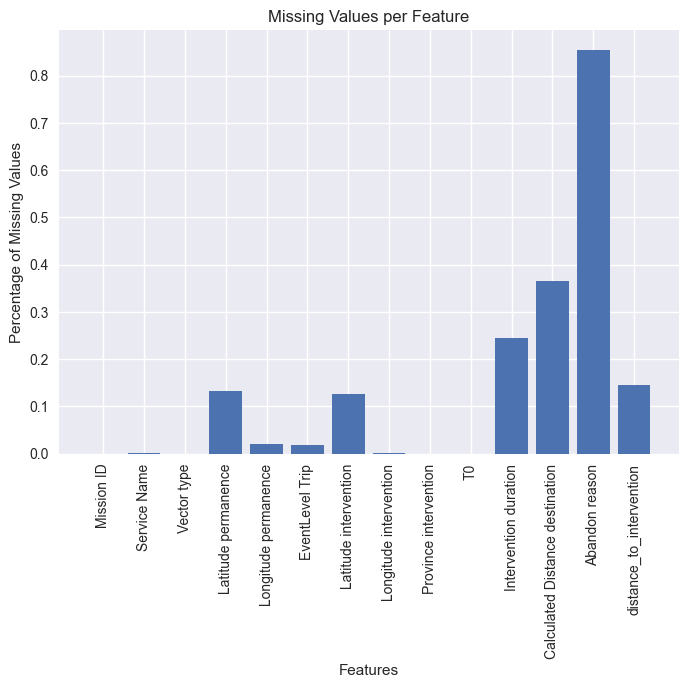

In [241]:
preprocess_1.missing_values_plot()

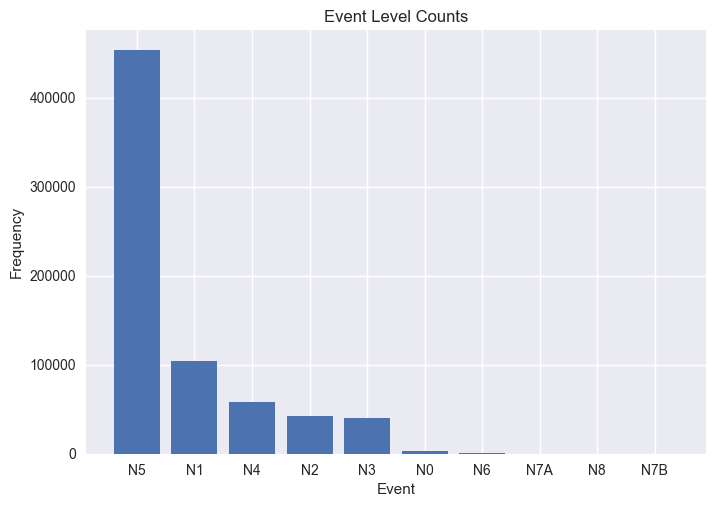

In [242]:
preprocess_1.event_level_plot()

In [243]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0


# Train-Test Split

In [264]:
X = interventions.drop("Risky", axis=1)
y = interventions["Risky"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
y.value_counts(normalize=True)

# Outliers

In [265]:
class outlier_handling:

    def __init__(self,dataset):
        self.dataset_train = dataset
        self.quant_columns  = self.dataset_train.select_dtypes(include=["int","float"]).drop(['Mission ID','Abandoned'],axis=1).columns
        

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Histograms of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].hist(self.dataset_train["T0"], bins="rice")
        ax[0, 1].hist(self.dataset_train["Intervention duration"], bins="rice")
        ax[1, 0].hist(self.dataset_train["Calculated Distance destination"], bins="rice")
        ax[1, 1].hist(self.dataset_train["distance_to_intervention"], bins="rice")
        ax[2, 0].hist(self.dataset_train["total_intervention_distance"], bins="rice")
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(self.dataset_train["T0"])
        ax[0, 1].boxplot(self.dataset_train["Intervention duration"])
        ax[1, 0].boxplot(self.dataset_train["Calculated Distance destination"])
        ax[1, 1].boxplot(self.dataset_train["distance_to_intervention"])
        ax[2, 0].boxplot(self.dataset_train["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

    def describe_dataset(self,dataset):
        return dataset.describe()
        



    def truncate_outliers_train(self):
        for feature_name in self.quant_columns:
            self.median = np.median(self.dataset_train[feature_name])
            q75, q25 = np.percentile(self.dataset_train[feature_name], [75 ,25])
            iqr = q75-q25
            k = 3*iqr + self.median
            self.dataset_train[feature_name] = np.where((abs((self.dataset_train[feature_name]  - self.median) / iqr)) > 3, k, self.dataset_train[feature_name] )

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Histograms of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].hist(self.dataset_train["T0"], bins="rice")
        ax[0, 1].hist(self.dataset_train["Intervention duration"], bins="rice")
        ax[1, 0].hist(self.dataset_train["Calculated Distance destination"], bins="rice")
        ax[1, 1].hist(self.dataset_train["distance_to_intervention"], bins="rice")
        ax[2, 0].hist(self.dataset_train["total_intervention_distance"], bins="rice")
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

        plt.style.use("seaborn-v0_8")
        # Creating histograms without specifying a particular style
        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(self.dataset_train["T0"])
        ax[0, 1].boxplot(self.dataset_train["Intervention duration"])
        ax[1, 0].boxplot(self.dataset_train["Calculated Distance destination"])
        ax[1, 1].boxplot(self.dataset_train["distance_to_intervention"])
        ax[2, 0].boxplot(self.dataset_train["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()

    def truncate_outliers_test(self, dataset_test):
        for feature_name in self.quant_columns:
            self.median = np.median(self.dataset_train[feature_name])
            q75, q25 = np.percentile(self.dataset_train[feature_name], [75 ,25])
            iqr = q75-q25
            k = 3*iqr + self.median
            dataset_test[feature_name] = np.where((abs((dataset_test[feature_name]  - self.median) / iqr)) > 3, k, dataset_test[feature_name] )

        fig, ax = plt.subplots(3, 2)

        fig.suptitle("Boxplots of Quantitative Features", fontsize=16)
        # Create histograms for each column
        ax[0, 0].boxplot(dataset_test["T0"])
        ax[0, 1].boxplot(dataset_test["Intervention duration"])
        ax[1, 0].boxplot(dataset_test["Calculated Distance destination"])
        ax[1, 1].boxplot(dataset_test["distance_to_intervention"])
        ax[2, 0].boxplot(dataset_test["total_intervention_distance"])
        # Set individual titles, x-labels, and y-labels for each subplot
        fig.delaxes(ax[2, 1])

        ax[0, 0].set_title("T0")
        ax[0, 1].set_title("Intervention Duration")
        ax[1, 0].set_title("Calculated Distance Destination")
        ax[1, 1].set_title("Distance to Intervention")
        ax[2, 0].set_title("Total Intervention Distance")

        plt.tight_layout()
        plt.show()



   


        


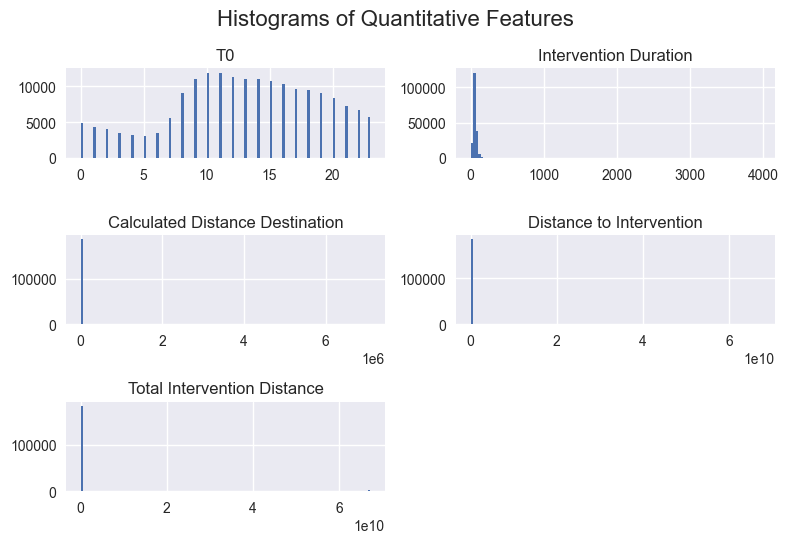

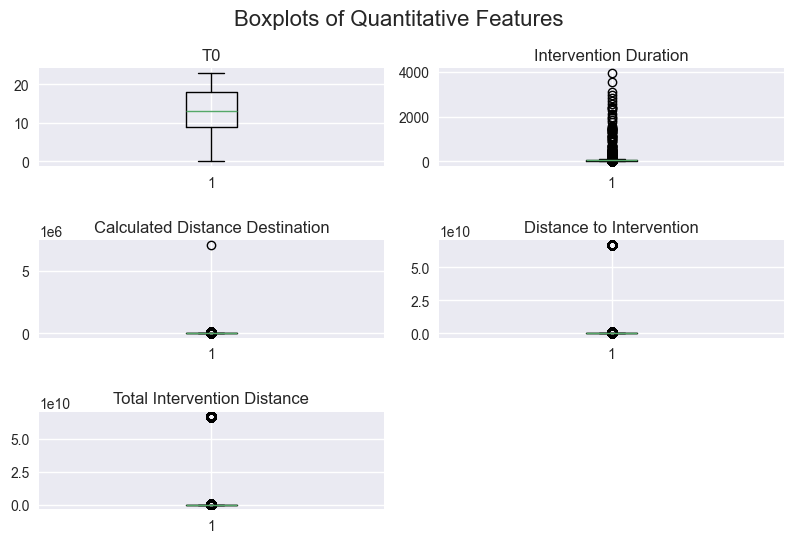

In [266]:
outlier = outlier_handling(X_train)

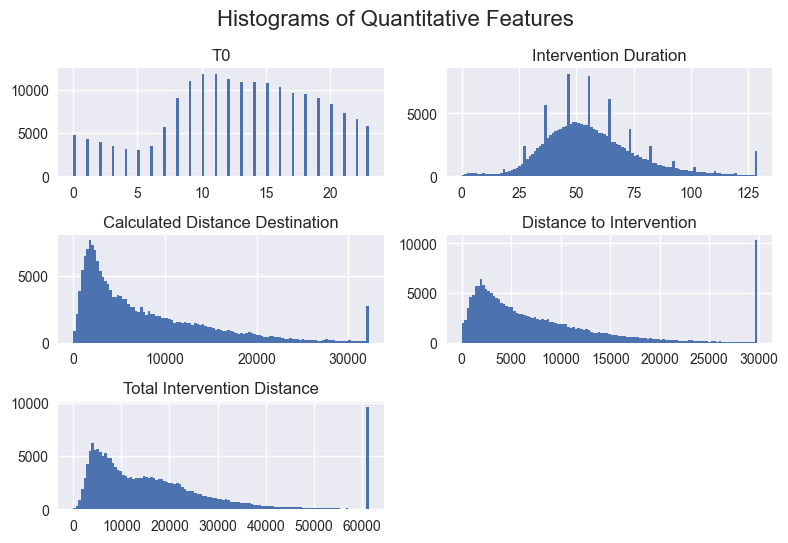

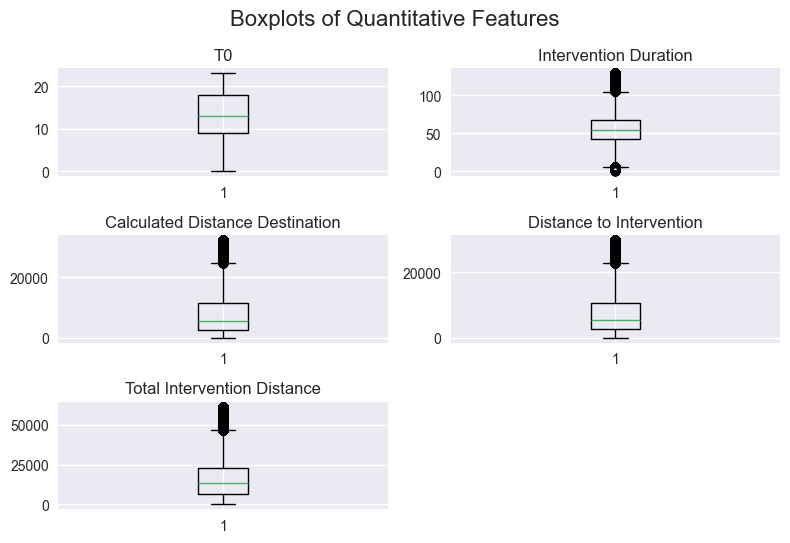

In [267]:
outlier.truncate_outliers_train()

In [270]:
outlier.describe_dataset(X_test)

,Mission ID,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,total_intervention_distance
count,7.978600e+04,79786.000000,79786.000000,79786.000000,79786.000000,79786.000000,79786.000000
mean,4.623268e+10,12.833931,56.602123,7901.154075,8068.015245,0.000175,17486.992550
std,2.671910e+10,5.898017,20.974586,7130.936363,7564.078135,0.013245,14694.559610
min,1.022152e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.022363e+10,9.000000,43.000000,2463.000000,2619.095075,0.000000,6689.466654
50%,5.022352e+10,13.000000,54.000000,5454.500000,5551.778661,0.000000,13500.923666
75%,7.022155e+10,17.000000,68.000000,11390.500000,10762.061727,0.000000,22711.985078
max,9.023091e+10,23.000000,129.000000,32243.000000,29833.158912,1.000000,61416.467129


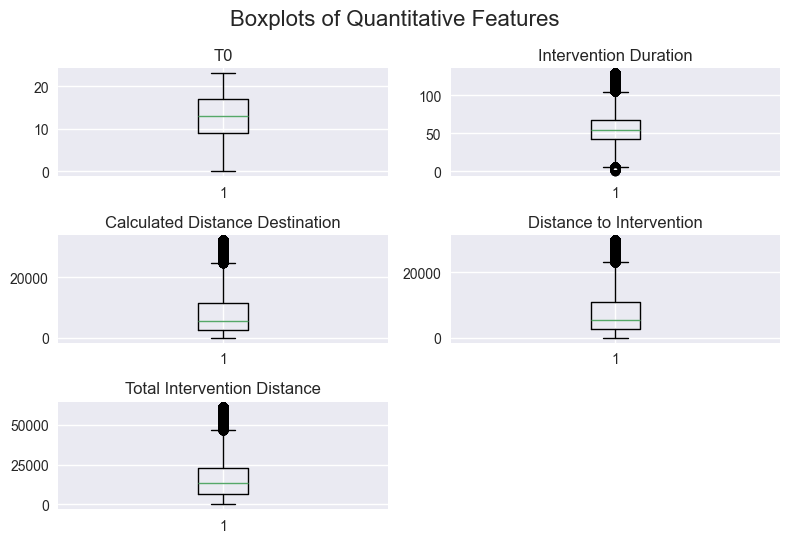

In [269]:
outlier.truncate_outliers_test(X_test)

# Class Imbalance 

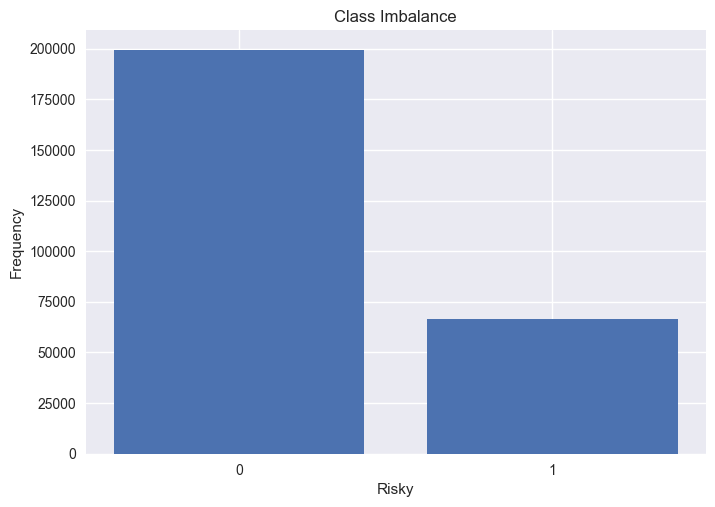

In [134]:
preprocess_1.class_imbalance()

In [135]:
interventions["Risky"].value_counts(normalize=True)

Risky
0.0    0.748944
1.0    0.251056
Name: proportion, dtype: float64

## Preprocessing Pipeline for Logistic


In [274]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0


In [275]:
columns_to_drop=["Mission ID", "Service Name","total_intervention_distance","Region","Intervention duration"]
one_hot_encode_columns=["Vector type","rush_hour","EventLevel Trip"]
woe_encode_columns=["Province intervention","time_period"]
standard_columns = ["distance_to_intervention","Calculated Distance destination","T0"]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first'), one_hot_encode_columns),
        ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('standardize', StandardScaler(), standard_columns)
    ],
    remainder='passthrough'
  )  

In [276]:
y_train.value_counts(normalize=True)

Risky
0    0.748946
1    0.251054
Name: proportion, dtype: float64

In [277]:
y_test.value_counts(normalize=True)

Risky
0    0.748941
1    0.251059
Name: proportion, dtype: float64

In [279]:
interventions_train = preprocessor.fit_transform(X_train,y_train)
interventions_train = pd.DataFrame(interventions_train, columns=preprocessor.get_feature_names_out())
interventions_train

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,standardize__distance_to_intervention,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,0.0,0.0,0.0,0.245206,-0.042603,0.100136,-0.636670,1.715532,0.0
1,0.0,0.0,0.0,0.0,0.245206,-0.025483,0.078003,2.108426,-0.315364,0.0
2,0.0,0.0,0.0,1.0,-0.157838,-0.042603,-0.851134,-0.733246,1.715532,0.0
3,0.0,0.0,0.0,0.0,0.217365,0.072329,-1.041045,-0.781675,0.192360,0.0
4,0.0,0.0,0.0,1.0,-0.157838,-0.077326,-0.766567,-0.058622,-1.838535,0.0
...,...,...,...,...,...,...,...,...,...,...
186162,0.0,0.0,0.0,0.0,-0.025579,0.072329,-0.156322,0.421584,0.361601,0.0
186163,0.0,0.0,1.0,0.0,-0.160709,0.028318,-0.637186,-0.705653,-0.484605,0.0
186164,0.0,0.0,0.0,0.0,-0.394921,-0.025483,2.889695,-0.815603,0.023119,0.0
186165,0.0,0.0,0.0,1.0,-0.157838,-0.077326,-0.020223,3.210182,-2.177018,0.0


In [281]:
interventions_test = preprocessor.transform(X_test)
interventions_test = pd.DataFrame(interventions_test, columns=preprocessor.get_feature_names_out())
interventions_test

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,standardize__distance_to_intervention,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,0.0,1.0,0.0,-0.025579,0.042188,0.091002,-0.257828,0.700084,0.0
1,0.0,0.0,0.0,0.0,-0.160709,0.072329,-0.252601,-0.685803,0.361601,0.0
2,0.0,0.0,1.0,1.0,0.217365,0.028318,-0.671830,0.739186,-0.484605,0.0
3,0.0,0.0,0.0,1.0,0.289502,-0.077326,-1.029184,-0.178708,-1.330811,0.0
4,0.0,0.0,0.0,0.0,-0.157838,-0.042603,-0.155855,0.317828,1.377049,0.0
...,...,...,...,...,...,...,...,...,...,...
79781,0.0,0.0,0.0,0.0,-0.157838,0.072329,-0.824758,-0.632447,0.361601,0.0
79782,0.0,0.0,1.0,0.0,-0.025579,0.042188,0.957924,-0.323854,1.038567,0.0
79783,0.0,0.0,1.0,0.0,-0.025579,0.028318,0.010627,-1.021285,-0.484605,0.0
79784,0.0,0.0,1.0,0.0,-0.394921,0.028318,-0.863092,-0.731839,-0.484605,0.0


Text(0.5, 1.0, 'Correlation Heatmap')

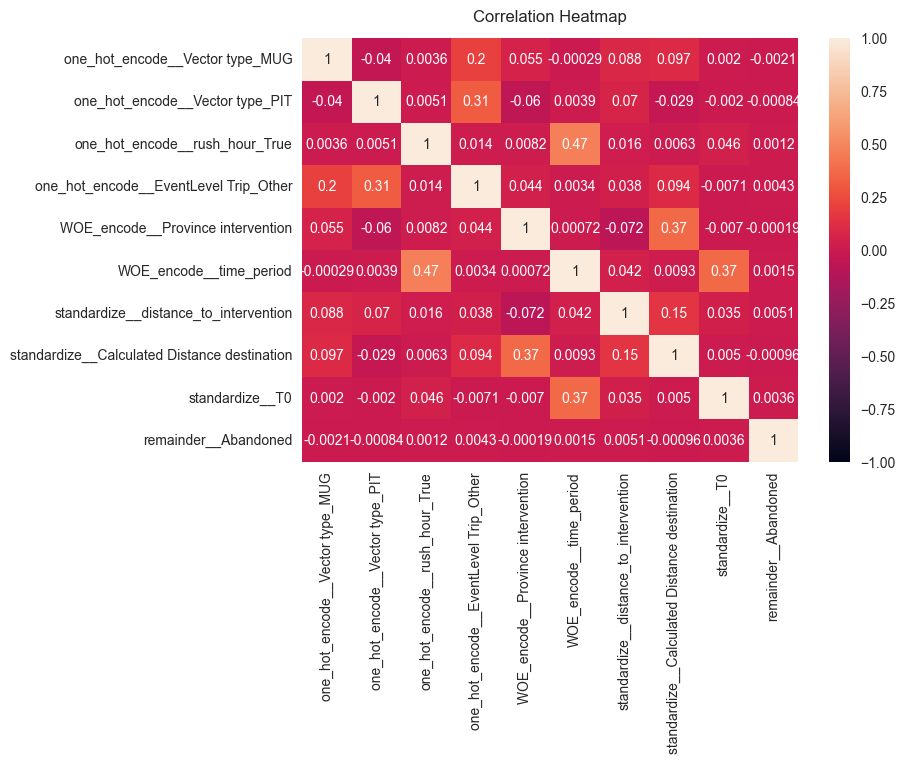

In [282]:
# plt.figure(figsize=(16, 6))
plt.figure()

heatmap = sns.heatmap(interventions_train.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## Logistic Ridge

In [146]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10.0,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1.0
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9.0,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0.0
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18.0,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0.0
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11.0,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1.0
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15.0,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0.0


In [351]:
lr = LogisticRegression(random_state=8, class_weight="balanced") 

param_grid = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)
# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher = GridSearchCV(lr, param_grid, cv=kf, scoring="precision")
searcher.fit(interventions_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=8),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='precision')

In [352]:
searcher.best_params_

{'C': 0.01}

In [353]:
lr = LogisticRegression(random_state=8,C=0.01) 
lr.fit(interventions_train,y_train)

LogisticRegression(C=0.01, random_state=8)

In [354]:
lr.coef_


array([[ 0.42089585,  0.44850686,  0.01889459,  0.55375981, -0.13256709,
         0.29535899,  0.23545881,  0.81570968,  0.0135119 , -0.01642094]])

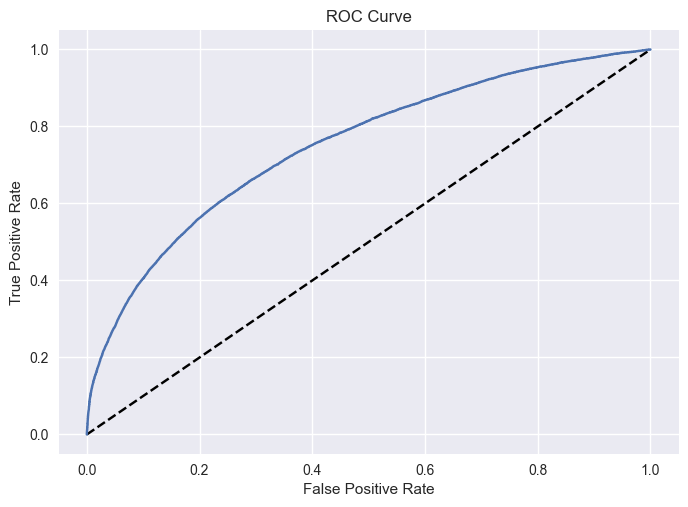

0.7499406599212272
[[56856  2899]
 [14482  5549]]
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     59755
         1.0       0.66      0.28      0.39     20031

    accuracy                           0.78     79786
   macro avg       0.73      0.61      0.63     79786
weighted avg       0.76      0.78      0.75     79786



In [355]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(interventions_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr.predict_proba(interventions_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr.predict(interventions_test)))

# Calculate the classification report
print(classification_report(y_test,  lr.predict(interventions_test)))

## Logistic Lasso

In [283]:
# Specify L1 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1
lr = LogisticRegression(solver='liblinear', penalty="l1",random_state=8, class_weight="balanced") 

param_grid = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_lasso = GridSearchCV(lr, param_grid, cv=kf, scoring="precision")
searcher_lasso.fit(interventions_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          random_state=8, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='precision')

In [284]:
searcher_lasso.best_params_

{'C': 1}

In [285]:
lr = LogisticRegression(solver='liblinear', penalty="l1",random_state=8,C=1) 
lr.fit(interventions_train,y_train)

LogisticRegression(C=1, penalty='l1', random_state=8, solver='liblinear')

In [286]:
mask_lasso = abs(lr.coef_) > 0
mask_lasso.shape
mask_lasso = mask_lasso[0]
mask_lasso

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
# reduced_train_lasso= X_train_preprocessed_smote.loc[:,mask_lasso]
# reduced_test_lasso = X_valid_preprocessed.loc[:,mask_lasso]
# reduced_train_lasso.head()

In [287]:
lr.fit(interventions_train,y_train)

LogisticRegression(C=1, penalty='l1', random_state=8, solver='liblinear')

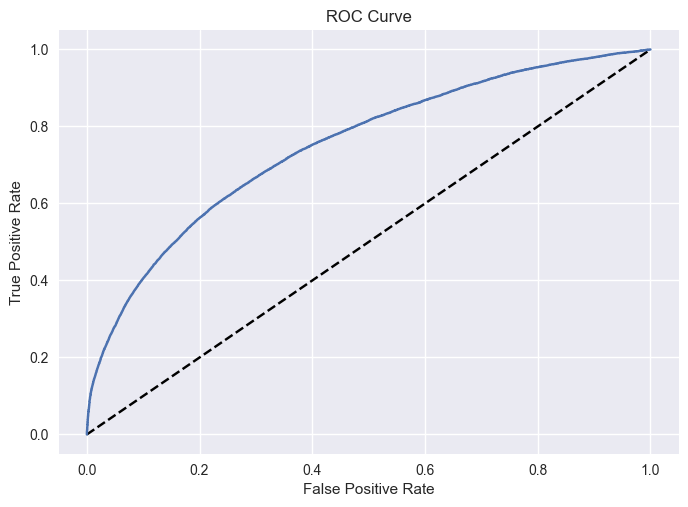

0.7500698346481036
[[56832  2923]
 [14439  5592]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     59755
           1       0.66      0.28      0.39     20031

    accuracy                           0.78     79786
   macro avg       0.73      0.62      0.63     79786
weighted avg       0.76      0.78      0.75     79786



In [288]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(interventions_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr.predict_proba(interventions_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr.predict(interventions_test)))

# Calculate the classification report
print(classification_report(y_test,  lr.predict(interventions_test)))

In [289]:
accuracy_score(y_test, lr.predict(interventions_test))

0.7823929010102023

## Logistic Step-Forward Selection

In [363]:

lr = LogisticRegression(random_state=8, max_iter=1000, class_weight="balanced")

pipeline = Pipeline(
    [
     ('selector',SequentialFeatureSelector(lr,cv=kf,scoring="accuracy")),
     ('model',lr)
    ]
)

param_grid = {
    'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'selector__n_features_to_select' : [1,2,3,4,5,6,7,8,9,10]

}

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_ridge = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring="precision", random_state=33)
searcher_ridge.fit(interventions_train, y_train)

c:\KU Leuven\Modern Data Analytics - MDA\MDA Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\KU Leuven\Modern Data Analytics - MDA\MDA Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\KU Leuven\Modern Data Analytics - MDA\MDA Project\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\KU Leuve

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=Pipeline(steps=[('selector',
                                              SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                                                                        estimator=LogisticRegression(class_weight='balanced',
                                                                                                     max_iter=1000,
                                                                                                     random_state=8),
                                                                        scoring='accuracy')),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=8))]),
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 10,
                                                     100, 1000],
                                        'selector__n_features_to_select': [1, 2,
                                                                           3, 4,
                                                                           5, 6,
                                                                           7, 8,
                                                                           9,
                                                                           10]},
                   random_state=33, scoring='precision')

In [364]:
searcher_ridge.best_params_

{'selector__n_features_to_select': 7, 'model__C': 0.001}

In [365]:
mask_step_ridge = searcher_ridge.best_estimator_.named_steps['selector'].support_
mask_step_ridge

array([ True,  True,  True, False, False,  True, False,  True,  True,
        True])

In [366]:
reduced_train_ridge_step = interventions_train.loc[:,mask_step_ridge]
reduced_test_ridge_step = interventions_test.loc[:,mask_step_ridge]
reduced_train_ridge_step.head()

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,WOE_encode__time_period,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,0.0,0.0,-0.042603,-0.636677,1.715532,0.0
1,0.0,0.0,0.0,-0.025483,2.108476,-0.315364,0.0
2,0.0,0.0,0.0,-0.042603,-0.733256,1.715532,0.0
3,0.0,0.0,0.0,0.072329,-0.781685,0.192360,0.0
4,0.0,0.0,0.0,-0.077326,-0.058617,-1.838535,0.0


In [367]:
lr_step = LogisticRegression(random_state=8, C=0.001)
lr_step.fit(reduced_train_ridge_step,y_train)

LogisticRegression(C=0.001, random_state=8)

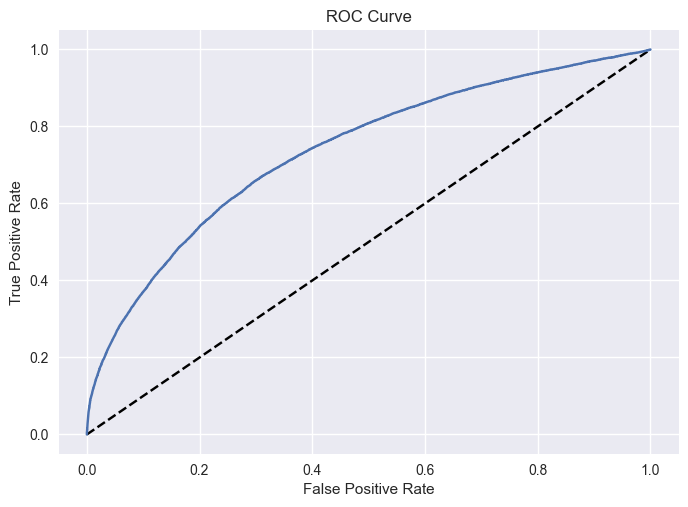

0.7371826614108352
[[57103  2652]
 [15174  4857]]
              precision    recall  f1-score   support

         0.0       0.79      0.96      0.86     59755
         1.0       0.65      0.24      0.35     20031

    accuracy                           0.78     79786
   macro avg       0.72      0.60      0.61     79786
weighted avg       0.75      0.78      0.74     79786



In [369]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_step.predict_proba(reduced_test_ridge_step)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_step.predict_proba(reduced_test_ridge_step)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_step.predict(reduced_test_ridge_step)))

# Calculate the classification report
print(classification_report(y_test,  lr_step.predict(reduced_test_ridge_step)))

# Random Forest 

## Preprocessing Random Forest

In [45]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10.0,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1.0
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9.0,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0.0
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18.0,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0.0
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11.0,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1.0
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15.0,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0.0


In [46]:
columns_to_drop=["Mission ID", "Service Name","total_intervention_distance","Region","Intervention duration"]
one_hot_encode_columns=["Vector type","rush_hour","EventLevel Trip"]
woe_encode_columns=["Province intervention","time_period"]
# standard_columns = ["distance_to_intervention","Calculated Distance destination","T0"]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first'), one_hot_encode_columns),
        ('WOE_encode', WOEEncoder(), woe_encode_columns),
        # ('standardize', StandardScaler(), standard_columns)
    ],
    remainder='passthrough'
  )  

In [47]:
interventions_train = preprocessor.fit_transform(X_train,y_train)
interventions_train = pd.DataFrame(interventions_train, columns=preprocessor.get_feature_names_out())
interventions_train

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,remainder__T0,remainder__Calculated Distance destination,remainder__distance_to_intervention,remainder__Abandoned
0,0.0,0.0,0.0,0.0,0.245206,-0.042603,23.0,3385.0,8799.046600,0.0
1,0.0,0.0,0.0,0.0,0.245206,-0.025483,11.0,22884.0,8632.159015,0.0
2,0.0,0.0,0.0,1.0,-0.157838,-0.042603,23.0,2699.0,1626.187806,0.0
3,0.0,0.0,0.0,0.0,0.217365,0.072329,14.0,2355.0,194.207383,0.0
4,0.0,0.0,0.0,1.0,-0.157838,-0.077326,2.0,7491.0,2263.850052,0.0
...,...,...,...,...,...,...,...,...,...,...
186162,0.0,0.0,0.0,0.0,-0.025579,0.072329,15.0,10902.0,6865.276823,0.0
186163,0.0,0.0,1.0,0.0,-0.160709,0.028318,10.0,2895.0,3239.420312,0.0
186164,0.0,0.0,0.0,0.0,-0.394921,-0.025483,13.0,2114.0,29868.089648,0.0
186165,0.0,0.0,0.0,1.0,-0.157838,-0.077326,0.0,30710.0,7891.504087,0.0


In [48]:
interventions_test = preprocessor.transform(X_test)
interventions_test = pd.DataFrame(interventions_test, columns=preprocessor.get_feature_names_out())
interventions_test

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,remainder__T0,remainder__Calculated Distance destination,remainder__distance_to_intervention,remainder__Abandoned
0,0.0,0.0,1.0,0.0,-0.025579,0.042188,17.0,6076.0,8730.179334,0.0
1,0.0,0.0,0.0,0.0,-0.160709,0.072329,15.0,3036.0,6139.306978,0.0
2,0.0,0.0,1.0,1.0,0.217365,0.028318,10.0,13158.0,2978.198362,0.0
3,0.0,0.0,0.0,1.0,0.289502,-0.077326,5.0,6638.0,283.639564,0.0
4,0.0,0.0,0.0,0.0,-0.157838,-0.042603,21.0,10165.0,6868.798041,0.0
...,...,...,...,...,...,...,...,...,...,...
79781,0.0,0.0,0.0,0.0,-0.157838,0.072329,15.0,3415.0,1825.075357,0.0
79782,0.0,0.0,1.0,0.0,-0.025579,0.042188,19.0,5607.0,15267.022926,0.0
79783,0.0,0.0,1.0,0.0,-0.025579,0.028318,10.0,653.0,8124.124431,0.0
79784,0.0,0.0,1.0,0.0,-0.394921,0.028318,10.0,2709.0,1536.024088,0.0


In [375]:
random_f = RandomForestClassifier(bootstrap=True,random_state=7)

grid_param = {
    "n_estimators" : [50,70,100,120,150],
    'criterion': ['gini','entropy'],
    'max_features' : [1,2,"log2"],
    'class_weight' : ["balanced", "balanced_subsample"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)


random_searcher = RandomizedSearchCV(random_f, grid_param, cv=kf,scoring="precision", random_state=33)
random_searcher.fit(interventions_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=RandomForestClassifier(random_state=7),
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_features': [1, 2, 'log2'],
                                        'n_estimators': [50, 70, 100, 120,
                                                         150]},
                   random_state=33, scoring='precision')

In [36]:
random_searcher.best_params_

NameError: name 'random_searcher' is not defined

In [58]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced')

random_f_best.fit(interventions_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=120, random_state=7)

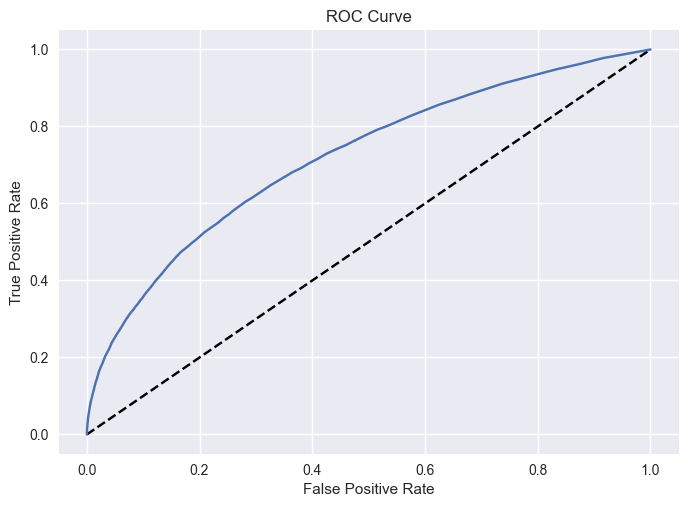

0.7198387011052456
[[54101  5654]
 [13064  6967]]
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85     59755
         1.0       0.55      0.35      0.43     20031

    accuracy                           0.77     79786
   macro avg       0.68      0.63      0.64     79786
weighted avg       0.74      0.77      0.75     79786



In [38]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(interventions_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(interventions_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(interventions_test)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(interventions_test)))

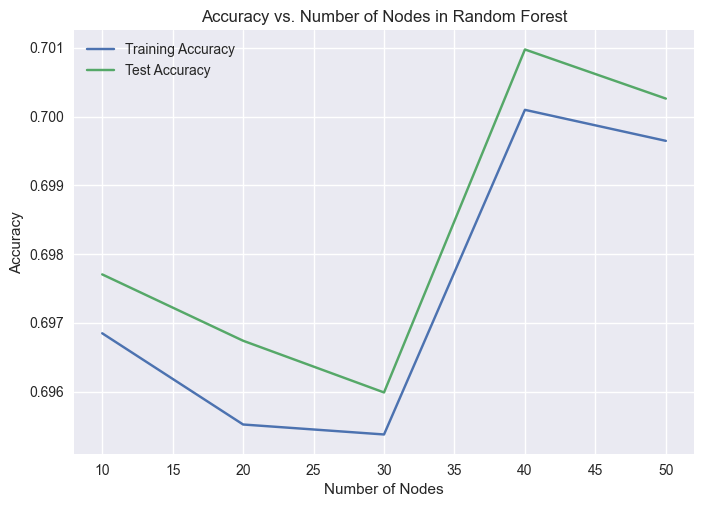

In [42]:
# Define a range of values for the number of nodes
node_values = [10,20,30,40,50]  # Adjust this range as needed

# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced', max_leaf_nodes=num_nodes)
    rf_model.fit(interventions_train, y_train)

    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(interventions_train)
    test_preds = rf_model.predict(interventions_test)
    
    # Calculate accuracy and append to lists
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Accuracy')
plt.plot(node_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()

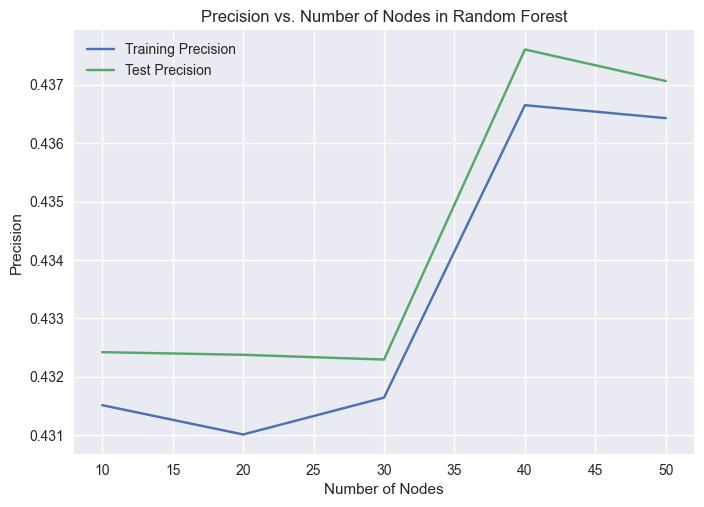

In [48]:
# Define a range of values for the number of nodes
# node_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100,110,120,130]  # Adjust this range as needed
node_values = [10,20,30,40,50]
# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced', max_leaf_nodes=num_nodes)
    rf_model.fit(interventions_train, y_train)

    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(interventions_train)
    test_preds = rf_model.predict(interventions_test)
    
    # Calculate accuracy and append to lists
    train_accuracy = precision_score(y_train, train_preds)
    test_accuracy = precision_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Precision')
plt.plot(node_values, test_accuracies, label='Test Precision')
plt.xlabel('Number of Nodes')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()

In [49]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced',max_leaf_nodes=40)

random_f_best.fit(interventions_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', max_leaf_nodes=40, n_estimators=120,
                       random_state=7)

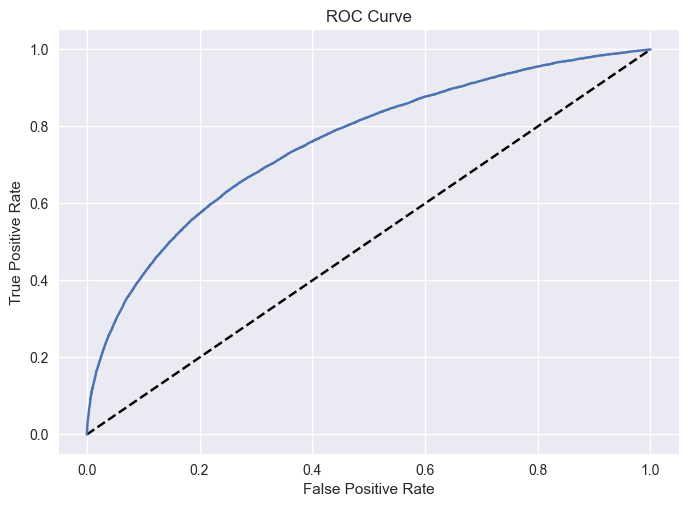

0.7570685247923455
[[42508 17247]
 [ 6611 13420]]
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78     59755
         1.0       0.44      0.67      0.53     20031

    accuracy                           0.70     79786
   macro avg       0.65      0.69      0.66     79786
weighted avg       0.76      0.70      0.72     79786



In [50]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(interventions_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(interventions_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(interventions_test)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(interventions_test)))

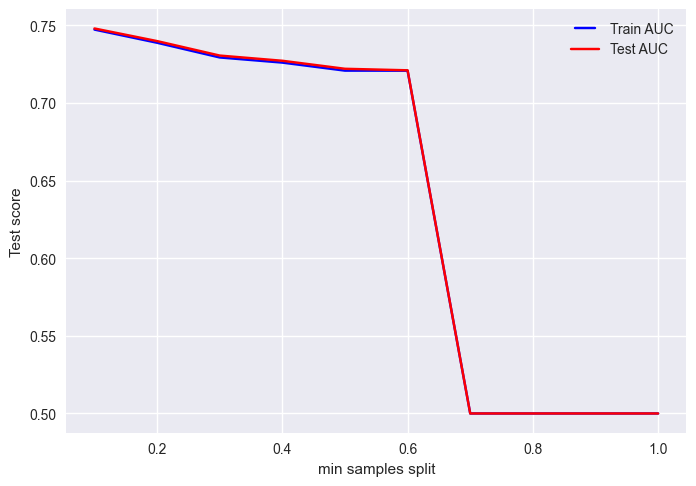

In [53]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced',min_samples_split=min_samples_split)
   rf.fit(interventions_train,y_train)  
   train_pred = rf.predict_proba(interventions_train)[:,1]  
   # false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   train_roc_auc_ = roc_auc_score(y_train,train_pred)
   # profit_train =calculate_profit_metric_2(y_train_split,train_pred,dataset=X_train_preprocessed)
   train_results.append(train_roc_auc_ )  
   valid_pred = rf.predict_proba(interventions_test)[:,1] 
   # false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   # roc_auc = auc(false_positive_rate, true_positive_rate)
   test_roc_auc_ = roc_auc_score(y_test,valid_pred)
   # profit_valid =calculate_profit_metric_2(y_valid_split,valid_pred,dataset=X_valid_preprocessed)
   test_results.append(test_roc_auc_)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Test score")
plt.xlabel("min samples split")
plt.show()

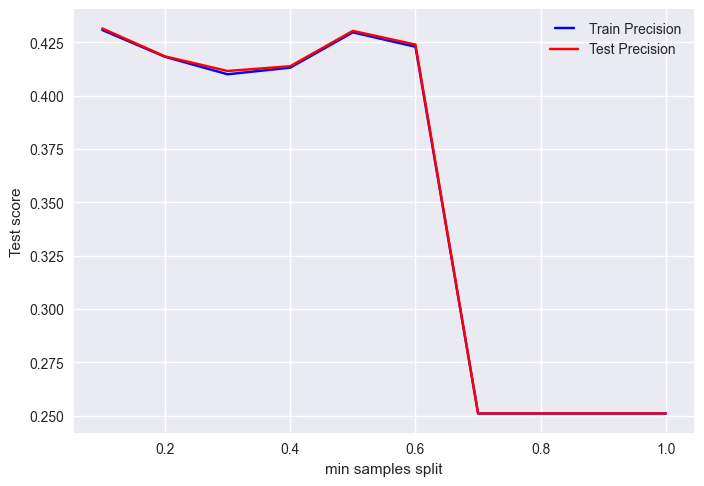

In [54]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced',max_leaf_nodes=5,min_samples_split=min_samples_split)
   rf.fit(interventions_train,y_train)  
   train_pred = rf.predict(interventions_train)
   # false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   # roc_auc = auc(false_positive_rate, true_positive_rate)
   profit_train = precision_score(y_train,train_pred)
   train_results.append(profit_train)  
   valid_pred = rf.predict(interventions_test) 
   # false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   # roc_auc = auc(false_positive_rate, true_positive_rate)
   profit_valid =precision_score(y_test,valid_pred)
   test_results.append(profit_valid)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train Precision")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test Precision")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Test score")
plt.xlabel("min samples split")
plt.show()

In [55]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced',min_samples_split=0.1)

random_f_best.fit(interventions_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', min_samples_split=0.1,
                       n_estimators=120, random_state=7)

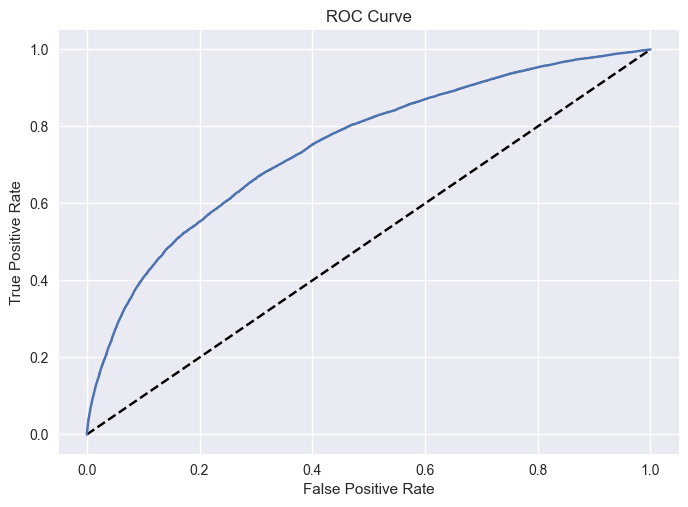

0.7480563794848634
[[41597 18158]
 [ 6608 13423]]
              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77     59755
         1.0       0.43      0.67      0.52     20031

    accuracy                           0.69     79786
   macro avg       0.64      0.68      0.65     79786
weighted avg       0.75      0.69      0.71     79786



In [56]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(interventions_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(interventions_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(interventions_test)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(interventions_test)))

## Random Forest - Grid Search (Cross Validation) - Feature Importance

In [ ]:
random_f = RandomForestClassifier(bootstrap=True,random_state=7)

grid_param = {
    "n_estimators" : [50,70,100,120,150],
    'criterion': ['gini','entropy'],
    'max_features' : [1,2,"log2"],
    'class_weight' : ["balanced", "balanced_subsample"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)


random_searcher = RandomizedSearchCV(random_f, grid_param, cv=kf,scoring="precision", random_state=33)
random_searcher.fit(interventions_train, y_train)

In [ ]:
random_searcher.best_params_

In [49]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced')

random_f_best.fit(interventions_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=120, random_state=7)

<Axes: >

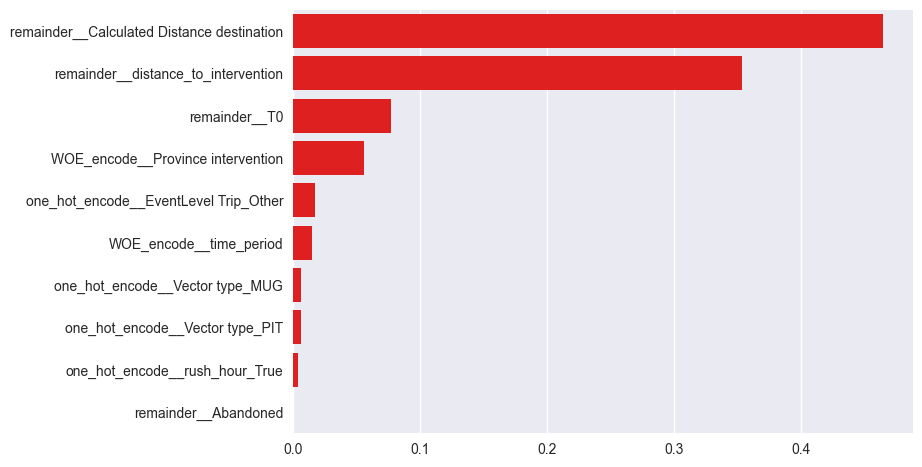

In [50]:
# Feature Importance 

diction = {key: value for key, value in zip(interventions_test.columns.values, random_f_best.feature_importances_)}
sorted_dict = dict(sorted(diction.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_dict.values()),y=list(sorted_dict.keys()),color="red")

In [51]:
interventions_train.columns

Index(['one_hot_encode__Vector type_MUG', 'one_hot_encode__Vector type_PIT',
       'one_hot_encode__rush_hour_True',
       'one_hot_encode__EventLevel Trip_Other',
       'WOE_encode__Province intervention', 'WOE_encode__time_period',
       'remainder__T0', 'remainder__Calculated Distance destination',
       'remainder__distance_to_intervention', 'remainder__Abandoned'],
      dtype='object')

In [52]:
subset_train_import = interventions_train[['remainder__Calculated Distance destination',
                                           'remainder__distance_to_intervention',
                                           'remainder__T0',
                                           'WOE_encode__Province intervention',
                                           'one_hot_encode__EventLevel Trip_Other']]

subset_test_import = interventions_test[['remainder__Calculated Distance destination',
                                           'remainder__distance_to_intervention',
                                           'remainder__T0',
                                           'WOE_encode__Province intervention',
                                           'one_hot_encode__EventLevel Trip_Other']]

In [53]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features="log2",random_state=7,criterion="entropy",n_estimators=120,class_weight='balanced')

random_f_best.fit(subset_train_import ,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=120, random_state=7)

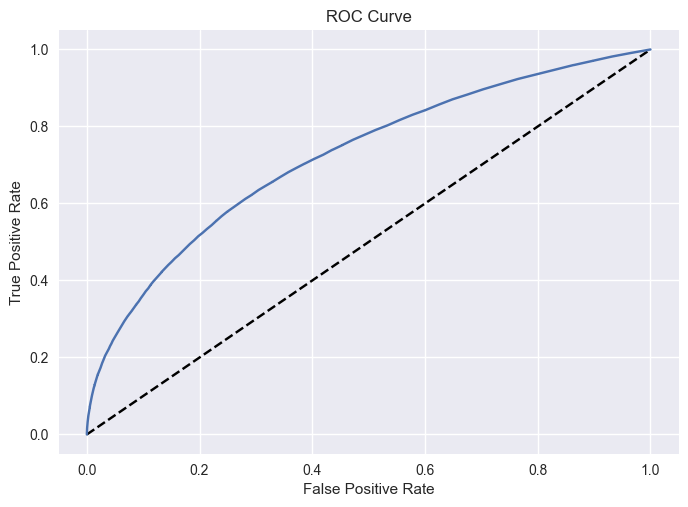

0.7223539723787097
[[54496  5259]
 [13257  6774]]
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     59755
         1.0       0.56      0.34      0.42     20031

    accuracy                           0.77     79786
   macro avg       0.68      0.63      0.64     79786
weighted avg       0.74      0.77      0.75     79786



In [73]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(subset_test_import)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(subset_test_import)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(subset_test_import)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(subset_test_import)))

In [54]:
accuracy_score(y_test, random_f_best.predict(subset_test_import))

0.7679292106384579

In [ ]:
#################### BEST ARE LOGISTIC LASSO AND RANDOM FOREST FEATURE IMPORTANCE #######################################

############################################# CREATE CLASS ##############################################################

################################## CLUSTER PROVINCES BASED ON MOST IMPORTANT FEATURES ##############################################

##################################### CLUSTER PROVINCES BASED ON PROBABILITY TO BE ABOVE OR BELOW THE 0.75 INTERVENTION DURATION ######################################

# Predict risk probability using Logistic Regression with Lasso Regularization

In [290]:
lr

LogisticRegression(C=1, penalty='l1', random_state=8, solver='liblinear')

In [291]:
lr.classes_

array([0, 1], dtype=int64)

In [292]:
lr.predict_proba(interventions_test)[:,1] 

array([0.16620884, 0.12010926, 0.38500617, ..., 0.09330695, 0.10082737,
       0.12436724])

In [153]:
interventions_test.head()

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,standardize__distance_to_intervention,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,0.0,1.0,0.0,-0.025579,0.042188,0.090680,-0.257827,0.700084,0.0
1,0.0,0.0,0.0,0.0,-0.160709,0.072329,-0.252670,-0.685811,0.361601,0.0
2,0.0,0.0,1.0,1.0,0.217365,0.028318,-0.671589,0.739208,-0.484605,0.0
3,0.0,0.0,0.0,1.0,0.289502,-0.077326,-1.028680,-0.178706,-1.330811,0.0
4,0.0,0.0,0.0,0.0,-0.157838,-0.042603,-0.155995,0.317840,1.377049,0.0


In [293]:
X.shape

(265953, 14)

In [294]:
X.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468


In [60]:
y.shape

(265953,)

In [58]:
interventions.shape

(265953, 15)

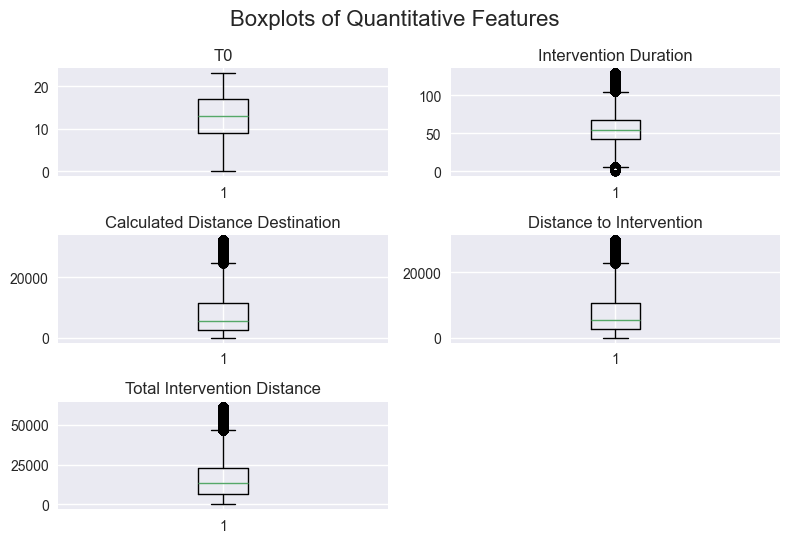

In [297]:
outlier.truncate_outliers_test(X)

In [298]:
interventions_preprocessed = preprocessor.transform(X)
interventions_preprocessed = pd.DataFrame(interventions_preprocessed, columns=preprocessor.get_feature_names_out())
interventions_preprocessed

,one_hot_encode__Vector type_MUG,one_hot_encode__Vector type_PIT,one_hot_encode__rush_hour_True,one_hot_encode__EventLevel Trip_Other,WOE_encode__Province intervention,WOE_encode__time_period,standardize__distance_to_intervention,standardize__Calculated Distance destination,standardize__T0,remainder__Abandoned
0,0.0,1.0,1.0,0.0,-0.394921,0.028318,-0.332054,-0.913587,-0.484605,0.0
1,0.0,1.0,1.0,0.0,-0.394921,0.028318,-0.889282,-0.839396,-0.653846,0.0
2,0.0,1.0,1.0,1.0,-0.394921,0.042188,-0.390085,-0.796598,0.869325,0.0
3,0.0,1.0,0.0,1.0,-0.160709,-0.025483,-0.567854,-0.477728,-0.315364,0.0
4,0.0,1.0,0.0,1.0,0.245206,0.072329,0.031033,0.194362,0.361601,0.0
...,...,...,...,...,...,...,...,...,...,...
265948,0.0,0.0,0.0,1.0,-0.025579,-0.025483,-0.824126,-1.108851,-0.146122,0.0
265949,0.0,0.0,0.0,0.0,-0.025579,-0.025483,-0.178040,-0.745354,-0.146122,0.0
265950,0.0,0.0,0.0,0.0,-0.025579,-0.025483,0.852073,0.045556,-0.146122,0.0
265951,0.0,0.0,0.0,0.0,-0.025579,-0.025483,1.959740,-0.725503,0.023119,0.0


In [299]:
probability_risk = lr.predict_proba(interventions_preprocessed)[:,1]

In [300]:
interventions["Probability_Risk"] = probability_risk

In [301]:
interventions.head()

,Mission ID,Service Name,Vector type,EventLevel Trip,Province intervention,T0,Intervention duration,Calculated Distance destination,distance_to_intervention,Abandoned,time_period,rush_hour,Region,total_intervention_distance,Risky,Probability_Risk
643173,20223420107,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,N5,BXL,10.0,84.0,1418.0,5540.210104,0,morning,True,Brussel,6958.210104,1,0.149735
641726,20223390102,HB UR BRUX CHU ST-PIERRE (PIT),PIT,N5,BXL,9.0,43.0,1945.0,1338.543238,0,morning,True,Brussel,3283.543238,0,0.141006
691468,20230880237,HB UR BRUX Iris Sud Etterbeek (PIT),PIT,Other,BXL,18.0,32.0,2249.0,5102.633242,0,evening,True,Brussel,7351.633242,0,0.253385
372961,60222810138,HG UR LIEG CHR Citadelle | PIT,PIT,Other,LIE,11.0,71.0,4514.0,3762.203850,0,noon,False,Waals Gewest,8276.203850,1,0.279707
567111,90222950115,HN UR NAMU CHR | PIT,PIT,Other,NAM,15.0,66.0,9288.0,8277.993468,0,afternoon,False,Waals Gewest,17565.993468,0,0.443047


In [302]:
interventions.groupby("Province intervention")["Probability_Risk"].mean()

Province intervention
ANT    0.228892
BRW    0.258046
BXL    0.170830
HAI    0.239455
LIE    0.235089
LIM    0.296616
LUX    0.399481
NAM    0.325796
Name: Probability_Risk, dtype: float64

In [303]:
interventions.groupby("Region")["Probability_Risk"].mean()

Region
Brussel          0.170830
Vlaams Gewest    0.252230
Waals Gewest     0.268334
Name: Probability_Risk, dtype: float64

In [304]:
lr.coef_.reshape(10,)

array([ 0.46286856,  0.47611875, -0.00959722,  0.55664914, -0.14352121,
        0.83177124,  0.23405387,  0.81995455,  0.0040702 , -0.29936042])

In [305]:
coefficients = lr.coef_.reshape(10,)
list(coefficients)

[0.4628685561273333,
 0.47611875286120053,
 -0.009597219149535815,
 0.5566491395062066,
 -0.14352121228709233,
 0.831771235830925,
 0.2340538678314926,
 0.8199545520568862,
 0.004070204845454003,
 -0.2993604216855027]

In [306]:
list(interventions_train.columns)

['one_hot_encode__Vector type_MUG',
 'one_hot_encode__Vector type_PIT',
 'one_hot_encode__rush_hour_True',
 'one_hot_encode__EventLevel Trip_Other',
 'WOE_encode__Province intervention',
 'WOE_encode__time_period',
 'standardize__distance_to_intervention',
 'standardize__Calculated Distance destination',
 'standardize__T0',
 'remainder__Abandoned']

In [307]:
feature_coeff = dict(zip(list(interventions_train.columns), list(coefficients)))
feature_coeff

{'one_hot_encode__Vector type_MUG': 0.4628685561273333,
 'one_hot_encode__Vector type_PIT': 0.47611875286120053,
 'one_hot_encode__rush_hour_True': -0.009597219149535815,
 'one_hot_encode__EventLevel Trip_Other': 0.5566491395062066,
 'WOE_encode__Province intervention': -0.14352121228709233,
 'WOE_encode__time_period': 0.831771235830925,
 'standardize__distance_to_intervention': 0.2340538678314926,
 'standardize__Calculated Distance destination': 0.8199545520568862,
 'standardize__T0': 0.004070204845454003,
 'remainder__Abandoned': -0.2993604216855027}

In [308]:
# Sort the dictionary by values in descending order
feature_coeff = dict(sorted(feature_coeff.items(), key=lambda item: item[1], reverse=True))

feature_coeff


{'WOE_encode__time_period': 0.831771235830925,
 'standardize__Calculated Distance destination': 0.8199545520568862,
 'one_hot_encode__EventLevel Trip_Other': 0.5566491395062066,
 'one_hot_encode__Vector type_PIT': 0.47611875286120053,
 'one_hot_encode__Vector type_MUG': 0.4628685561273333,
 'standardize__distance_to_intervention': 0.2340538678314926,
 'standardize__T0': 0.004070204845454003,
 'one_hot_encode__rush_hour_True': -0.009597219149535815,
 'WOE_encode__Province intervention': -0.14352121228709233,
 'remainder__Abandoned': -0.2993604216855027}

# Linear Model to identify feature affect on intervention duration

In [ ]:
columns_to_drop=["Mission ID", "Service Name","total_intervention_distance","Region","Abandoned"]
one_hot_encode_columns=["Vector type","rush_hour","EventLevel Trip"]
# woe_encode_columns=["Province intervention"]
standard_columns = ["T0","distance_to_intervention","Calculated Distance destination","Intervention duration"]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first'), one_hot_encode_columns),
        # ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('standardize', StandardScaler(), standard_columns)
    ],
    remainder='passthrough'
  )  